In [29]:
import logging
import pandas as pd
import numpy as np
import jieba
import random
from gensim.models import word2vec

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torch.autograd import Variable
from sklearn.metrics import accuracy_score

# w2v

## non split data

In [112]:
# Loading dataset
train = pd.read_csv('train.csv')
train
val = pd.read_csv('validation.csv')
val

,Content,Label
0,我有個國小認識的好朋友，上了大學後常常會跟我訴苦，大多是關於人際關係的他個性比較內向，不容易...,0
1,(第一人稱視角，)媽媽跟爸爸從我出生就感情不好 所以國小時離婚了我喜歡媽媽 不喜歡爸爸但我們...,1
2,我的前任在自殺前一周突然幫我慶生，一天前找我出門玩，再一聲不吭的自我了斷，給我很大的陰影。現...,0
3,身為一個亞斯伯格症的人看到這則新聞還蠻難過的首先我可以理解家長看到自己小孩無緣無故被攻擊而想...,0
4,真的很長，防雷。26個年頭來，經歷了大小事情。媽媽在國小開始因為經濟不景氣、收店的壓力、被朋...,0
...,...,...
249,我是1995年出生，我妹則是1999年出生，過去這兩年我們家歷經了非常嚴重的衝突。我和我妹都...,0
250,我有個水瓶男好朋友他會跟我說相處自在點他都是想怎樣就怎樣很隨性我也有點這樣所以我們才能成為好...,0
251,如題小時候我真的是活在陰影下...從我有印象第一次被打的那時候開始講吧！那時我才國中一年級 ...,0
252,如標題我現在已經滿20了，我家在北部但是在外縣市讀書當初高中填志願的時候就是為了逃離我媽才把...,0


In [14]:
## 取200筆非自殺
# train_neg = train[train["Label"] == 0].iloc[:200]
# train_pos = train[train["Label"] == 1]
# train = pd.concat([train_neg,train_pos])
# train = train.reset_index(drop=True)
# train

,Content,Label
0,仙草加蜂蜜好好吃！等下再去市場買一塊大仙草~吃吃吃好像把今天的熱量扣打吃完了-----Sen...,0
1,啊啊啊 邁入老女人的里程碑了今天本來想請假的但被同事搶先了然後從禮拜六開始爸爸媽媽就滿滿的情...,0
2,今天同事提出，覺得我有點過度依賴男友了不是第一個人說出這個問題其實早在交往的一開始我自己就察...,0
3,開始停速悅的這幾天我還是會吃安立平總覺得現在除了心悸手抖頭很重以外一直還有個在耳邊敲打小軍鼓...,0
4,我覺得有些善意的謊言是可以說的就是那些不會被揭穿的但有一些是一定會被揭穿「你狀態不好的時侯可...,0
...,...,...
298,很想一走了之。從人生這場遊戲登出。去年以前，厭食了6年去年開始暴食。或許我恨的是自己所以什麼...,1
299,要嘛給我愛，要嘛給我錢，要嘛給我滾。其實你連當炮友的資格都沒有，憑什麼跟我談戀愛？無法給我愛...,1
300,以為可以好一陣子不用上來發文了生命又再次賞我好一大巴掌我真的真的真的很努力很努力了我為甚麼總...,1
301,從四年前，一直都有失眠的小問題，但都是以作息不正常來解套自己的想法。前年二月到六月，我的狀況...,1


## Split Data

In [113]:
total = pd.concat([train, val])
total = total.reset_index(drop=True)
total

,Content,Label
0,仙草加蜂蜜好好吃！等下再去市場買一塊大仙草~吃吃吃好像把今天的熱量扣打吃完了-----Sen...,0
1,啊啊啊 邁入老女人的里程碑了今天本來想請假的但被同事搶先了然後從禮拜六開始爸爸媽媽就滿滿的情...,0
2,今天同事提出，覺得我有點過度依賴男友了不是第一個人說出這個問題其實早在交往的一開始我自己就察...,0
3,開始停速悅的這幾天我還是會吃安立平總覺得現在除了心悸手抖頭很重以外一直還有個在耳邊敲打小軍鼓...,0
4,我覺得有些善意的謊言是可以說的就是那些不會被揭穿的但有一些是一定會被揭穿「你狀態不好的時侯可...,0
...,...,...
1604,我是1995年出生，我妹則是1999年出生，過去這兩年我們家歷經了非常嚴重的衝突。我和我妹都...,0
1605,我有個水瓶男好朋友他會跟我說相處自在點他都是想怎樣就怎樣很隨性我也有點這樣所以我們才能成為好...,0
1606,如題小時候我真的是活在陰影下...從我有印象第一次被打的那時候開始講吧！那時我才國中一年級 ...,0
1607,如標題我現在已經滿20了，我家在北部但是在外縣市讀書當初高中填志願的時候就是為了逃離我媽才把...,0


In [114]:
total_0 = total[total["Label"] == 0]
total_1 = total[total["Label"] == 1]
total_1

,Content,Label
11,不知道為什麼最近一直很想上吊可能是找不到工作可能是人際讓我不行可能是學業上的困難不知道欸感覺...,1
17,我四月~八月都處於超憂鬱的狀態一直有想死的念頭但八月開始，我一直處於很興奮的狀態，也不較不會...,1
25,十年了已經不知道吃了多少要跟換過多少醫生朋友都從身邊離去被趕出家庭什麼都沒了每天吃的藥多到不...,1
38,前幾天有試過離開但可能方法不對吧感覺還是會有痛苦存在突然有點羨幕那種在睡夢中昏迷且死亡的--...,1
55,活著好累，著手計畫一切，五個月，把所有痛苦不甘一次解決現在的人到底還有誰有著夢想，其實我們出...,1
...,...,...
1583,我知道根本不會有人點進來，也知道不會有多少人會理我。我知道我對你們來說，只是一個毫不在意的陌...,1
1588,我想要自殺，我是生下來就有障礙過得比其他人辛苦活不下去了，不知道有沒有人想過自殺，目前決定其...,1
1589,目前這份工作已經做了一年又三個月，也是我以社會新鮮人姿態出社會的第一份工作，這一年一路走過來...,1
1590,在北上的路途中看見了防治自殺的文章，我就不自覺的哭出來了，我討厭我的家庭，我愛我的家庭，我好...,1


In [148]:
# Label_1
num_1 = total_1.shape[0]
random_1 = random.sample(range(num_1), num_1)
train_1 = total_1.iloc[random_1[:95]]
test_1 = total_1.iloc[random_1[95:135]]
train_1

,Content,Label
1383,明天是開學日一想到又要跟人頻繁的接觸就覺得既焦慮又恐懼希望睡著後能夠永遠不再醒來不知道從什麼...,1
694,(...續) (雷)He who has a why can bear almost any...,1
1404,轉眼間半年過去了我已經很努力的活著了，不論是過去、還是現在但是當我期望會更好時，等待我的卻只...,1
661,前幾天爆炸了 而且連續兩天或許是因為天氣熱或許是因為我的心理師要回學校所以諮商結束了或許是因...,1
1466,我目前只想到一個就是燒炭但是我又不想讓我家變凶宅所以地點蠻難選擇的希望有人提供那種自殺不會痛...,1
...,...,...
287,軟爛的身軀沒辦法再容納更高純度的傷悲。時光暴雨如樁，心裡累長的青苔無能被日光寵幸，只有迤邐著...,1
272,後悔昨天沒有將刀刺進喉嚨痛恨自己的軟弱無力每次覺得好像好一點點馬上就又被排山倒海的自殺意念襲...,1
1451,如題我一直被家人說要拿兩千塊出來繳電費雖然不是很多，但我還只是跟學生，平常因為學校的關係，能...,1
1552,好累好無助 對自己要求好高 但我對自己太失望了每分每秒都很痛苦 只有睡覺是快樂的人生當中重來...,1


In [149]:
# Label_0
num_0 = total_0.shape[0]
random_0 = random.sample(range(num_0), num_0)
train_0 = total_0.iloc[random_0[:1031]]
test_0 = total_0.iloc[random_0[1031:1609]]
train_0

,Content,Label
411,各位版友們好我自己認為有憂鬱傾向好一陣時日了，最近覺得影響到生活，決定在學業方面休息一陣子，...,0
87,好開心接龍文復出今天久違的跑步但我一副快死的樣子皮膚會過敏，眼睛一片黑然後，這禮拜跟新朋友講...,0
908,今天忘記帶手機了但是沒有PTT的人生好難過XDDD於是已經好幾年沒有用電腦上過PTT的我，想...,0
1112,我有一個你們不知道的我存在在那個地下室，他是不堪、違反道德、虛榮、自私、陰鬱的那個我。我曾經...,0
1266,腳扭傷了傷勢已經不算嚴重，不過幾天無法跑跳，走路跛腳是跑不掉的事情發生的當下，所有人都說我好...,0
...,...,...
1470,看完全部留言刷新我的三觀美醜是很主觀的事沒錯“覺得不好看可以針對妝容批評”但是罵別人『長好醜...,0
1050,每到睡前就會難受其實不是只有睡前，而是腦袋不得不空下來真正的感受就浮出來了2月的時候，報名了...,0
377,煩死了 我 我好煩啊啊啊啊啊啊到底要這樣子搞多久 煩死了煩死了煩死了煩死了不要再吃完安眠藥之...,0
23,各位早安鄙人長期有失眠及注意力不足的問題，也因而導致情緒容易緊張、低落，目前持續在吃治療的藥...,0


In [155]:
# train_val_1
train_val_1 = train_1.shape[0]
random_train_val = random.sample(range(train_val_1), train_val_1)
train__1 = train_1.iloc[random_train_val[:81]]
val_1 = train_1.iloc[random_train_val[81:95]]
val_1

,Content,Label
694,(...續) (雷)He who has a why can bear almost any...,1
1442,最近因為一些事情，憂鬱症又開始復發了，我想回去找醫生，這怕看到醫生又不知道講什麼，只能靜靜的...,1
507,我還是離開了到最後還是沒人理解我也許真的是我的問題吧我真的是個人渣 自私到極點了好想離開 離...,1
1533,從小父母離婚，我和弟弟跟著媽媽媽媽從來沒有工作、又重男輕女我升上高中之後就沒有跟媽媽拿過錢吃...,1
1458,半夜總是失眠，藥物好多呀······重度憂鬱症什麼時候好呀下週要進住宿舍半夜睡不著，會不會吵...,1
672,上吊、捅自己心臟是我想到目前可以快點死的方式死亡意念的週期又來了覺得很煩、沒有目標、只想結束...,1
658,我覺得我做人很失敗明明知道這樣是不對的但還是會去做越來越無法控制自己的情緒常常把氣出在身邊的...,1
1388,想請問各位如果不在租屋處自殺的話在哪執行會比較好呢雖然房東很煩又很貪小便宜、環境又爛但我也不...,1
73,從五月辭職到現在一直對工作感到焦慮緊張六月去了一間步調很快的公司結果大爆炸辭職現在一直不知道...,1
458,害怕出門害怕電鈴害怕見到人害怕電話每天都吃不下什麼東西心都是空空的痛痛的到底在痛什麼怕什麼總...,1


In [156]:
# train_val_0
train_val_0 = train_0.shape[0]
random_train_val = random.sample(range(train_val_0), train_val_0)
train__0 = train_0.iloc[random_train_val[:876]]
val_0 = train_0.iloc[random_train_val[876:1031]]
val_0

,Content,Label
1240,當時因為很多事情爆炸割腕，當時在一群人在dc聊天最後就一邊聊一邊說話也會說出自己在幹嘛好不容...,0
1112,我有一個你們不知道的我存在在那個地下室，他是不堪、違反道德、虛榮、自私、陰鬱的那個我。我曾經...,0
697,聽到爸媽罵兒女「大逆不道」，好像會有一種老派、不合時宜的感覺，進而產生一種滑稽、幽默感。儘管...,0
1269,感覺到自己不好想要讓人知道，想要被拍拍但是我不想造成別人的困擾，也不想好像是在尋求關注(我還...,0
1539,妳過的好嗎？分手之後的我們曾像這般簡單地噓寒問暖，但那種沒有意義的對話，實質地讓我感到難受。...,0
...,...,...
495,雜訊很多，某些片段畫面、文字、話語像是電視上的雜訊一般，會在生活中突然閃現，無法控制的產生一...,0
381,記得是26歲失戀那時開始的，我瘋狂買衣服，揣想他的喜好，想證明自己是有魅力的，買我的，也買他...,0
566,台北好熱熱到很易怒沒開冷氣快受不了了我們就是窮 想開想換都要精打細算易怒之後就會口出惡言但我...,0
69,情緒勒索真的煩逼別人答應你的要求真的夠了喔有夠難過的明明做了很多對方總覺得不夠一直變本加厲我...,0


In [157]:
# train_val
train = pd.concat([train__1, train__0])
train = train.reset_index(drop=True)
val = pd.concat([val_1, val_0])
val = val.reset_index(drop=True)
val

,Content,Label
0,(...續) (雷)He who has a why can bear almost any...,1
1,最近因為一些事情，憂鬱症又開始復發了，我想回去找醫生，這怕看到醫生又不知道講什麼，只能靜靜的...,1
2,我還是離開了到最後還是沒人理解我也許真的是我的問題吧我真的是個人渣 自私到極點了好想離開 離...,1
3,從小父母離婚，我和弟弟跟著媽媽媽媽從來沒有工作、又重男輕女我升上高中之後就沒有跟媽媽拿過錢吃...,1
4,半夜總是失眠，藥物好多呀······重度憂鬱症什麼時候好呀下週要進住宿舍半夜睡不著，會不會吵...,1
...,...,...
164,雜訊很多，某些片段畫面、文字、話語像是電視上的雜訊一般，會在生活中突然閃現，無法控制的產生一...,0
165,記得是26歲失戀那時開始的，我瘋狂買衣服，揣想他的喜好，想證明自己是有魅力的，買我的，也買他...,0
166,台北好熱熱到很易怒沒開冷氣快受不了了我們就是窮 想開想換都要精打細算易怒之後就會口出惡言但我...,0
167,情緒勒索真的煩逼別人答應你的要求真的夠了喔有夠難過的明明做了很多對方總覺得不夠一直變本加厲我...,0


In [158]:
# test
test = pd.concat([test_1, test_0])
test = test.reset_index(drop=True)
test

,Content,Label
0,每次看到社會新聞總想著怎麼不是自己被撞死被砍死各種死亡我沒有死的勇氣卻也痛苦的活著好痛苦好痛...,1
1,認真問身穿紅衣自殺表示怨氣很重通常是上吊著紅衣的案例比較多因為上吊同樣是恨意很強烈的自殺方式...,1
2,好累自殺之前都會想到家人我好慚愧我好沒用什麼事都做不了連跟媽媽溝通都不會我真的好無能我能做甚...,1
3,結束了，一切都結束了。我不值得被愛，不值得對我好。我死了也不會來上香吧！那就死了吧。--,1
4,今天是我的生日去年的7/8開始到今年的7/8經歷過好幾次想不開酗酒自殘可是還是活下來了聽說2...,1
...,...,...
478,分手辭職後逃回家休養的這一年半裡可以說根本沒出過一次門大概就是去小七買個東西或是買個早餐吃其...,0
479,躲在角落還是狂冒冷汗諮商師開了小房間的燈跟我說如果有需要可以進去搖頭拒絕之後發現有人盯著我看...,0
480,為了看影片練琴，去老哥房間偷偷拿他的筆電瞬間又想到這幾年發生的事、這幾個月發生的事想到愛人的...,0
481,文筆不好只想問大家要怎麼能做到愛自己我很疑惑--,0


## tokenized

In [118]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# jieba custom setting.
jieba.set_dictionary('jieba_dict/dict.txt.big')

# load stopwords set
stopword_set = set()
with open('jieba_dict/stopwords.txt','r', encoding='utf-8') as stopwords:
    for stopword in stopwords:
        stopword_set.add(stopword.strip(' \n'))

In [119]:
def jieba_tokenizer(content):
    if str(content)=='nan':
        return ''
    words = jieba.cut(content.replace(' ',''))
    return [word for word in words if word not in stopword_set]

In [175]:
train['tokenized'] = list(train.loc[:, 'Content'].apply(jieba_tokenizer))
val['tokenized'] = list(val.loc[:, 'Content'].apply(jieba_tokenizer))
test['tokenized'] = list(test.loc[:, 'Content'].apply(jieba_tokenizer))
val['tokenized']

0      [續, 雷, Hewhohasawhycanbearalmostanyhow, 尼采, 自我...
1      [最近, 因為, 一些, 事情, 憂鬱症, 開始, 復發, 想, 回去, 找, 醫生, 這怕...
2      [還是, 離開, 最後, 還是, 沒, 理解, 也許, 真的, 問題, 真的, 個人, 渣,...
3      [從小, 父母, 離婚, 弟弟, 媽媽, 媽媽, 從來, 工作, 重男輕女, 我升, 高中,...
4      [半夜, 總是, 失眠, 藥物, 好多, 呀, ·, ·, ·, ·, ·, ·, 重度, ...
                             ...                        
164    [雜訊, 很多, 某些, 片段, 畫面, 文字, 話語, 像是, 電視, 雜訊, 一般, 會...
165    [記得, 26, 歲, 失戀, 那時, 開始, 瘋狂, 買, 衣服, 揣想, 喜好, 想, ...
166    [台北, 熱熱, 易怒, 沒, 開, 冷氣, 快, 受不了, 就是, 窮, 想開, 想換, ...
167    [情緒, 勒索, 真的, 煩, 逼, 別人, 答應, 要求, 真的, 夠了, 喔, 有夠, ...
168    [康復, 只是, 暫時, 地請, 一天, 兩天, 假, 希望, 別有, 第三天, 週一, 狀...
Name: tokenized, Length: 169, dtype: object

In [124]:
from gensim.models import KeyedVectors
w2v_model = KeyedVectors.load("w2v_model.wv", mmap='r')

2020-11-07 14:41:36,493 : INFO : loading Word2VecKeyedVectors object from w2v_model.wv
2020-11-07 14:41:51,882 : INFO : loading vectors from w2v_model.wv.vectors.npy with mmap=r
2020-11-07 14:41:52,500 : INFO : setting ignored attribute vectors_norm to None
2020-11-07 14:41:52,512 : INFO : loaded w2v_model.wv


In [125]:
# Retrieve the weights from the model. This is used for initializing the weights
# in a Keras Embedding layer later
w2v_weights = w2v_model.wv.vectors # If use pytorch add torch.from_numpy()
vocab_size, embedding_size = w2v_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
def token2word(token):
    return w2v_model.wv.index2word[token]

Vocabulary Size: 883958 - Embedding Dim: 250


/home/ubuntu-gpu/anaconda3/envs/trainEnv/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [176]:
import copy
train['word_vec'] = copy.deepcopy(train['tokenized'])
val['word_vec'] = copy.deepcopy(val['tokenized'])
test['word_vec'] = copy.deepcopy(test['tokenized'])
val

,Content,Label,tokenized,word_vec
0,(...續) (雷)He who has a why can bear almost any...,1,"[續, 雷, Hewhohasawhycanbearalmostanyhow, 尼采, 自我...","[續, 雷, Hewhohasawhycanbearalmostanyhow, 尼采, 自我..."
1,最近因為一些事情，憂鬱症又開始復發了，我想回去找醫生，這怕看到醫生又不知道講什麼，只能靜靜的...,1,"[最近, 因為, 一些, 事情, 憂鬱症, 開始, 復發, 想, 回去, 找, 醫生, 這怕...","[最近, 因為, 一些, 事情, 憂鬱症, 開始, 復發, 想, 回去, 找, 醫生, 這怕..."
2,我還是離開了到最後還是沒人理解我也許真的是我的問題吧我真的是個人渣 自私到極點了好想離開 離...,1,"[還是, 離開, 最後, 還是, 沒, 理解, 也許, 真的, 問題, 真的, 個人, 渣,...","[還是, 離開, 最後, 還是, 沒, 理解, 也許, 真的, 問題, 真的, 個人, 渣,..."
3,從小父母離婚，我和弟弟跟著媽媽媽媽從來沒有工作、又重男輕女我升上高中之後就沒有跟媽媽拿過錢吃...,1,"[從小, 父母, 離婚, 弟弟, 媽媽, 媽媽, 從來, 工作, 重男輕女, 我升, 高中,...","[從小, 父母, 離婚, 弟弟, 媽媽, 媽媽, 從來, 工作, 重男輕女, 我升, 高中,..."
4,半夜總是失眠，藥物好多呀······重度憂鬱症什麼時候好呀下週要進住宿舍半夜睡不著，會不會吵...,1,"[半夜, 總是, 失眠, 藥物, 好多, 呀, ·, ·, ·, ·, ·, ·, 重度, ...","[半夜, 總是, 失眠, 藥物, 好多, 呀, ·, ·, ·, ·, ·, ·, 重度, ..."
...,...,...,...,...
164,雜訊很多，某些片段畫面、文字、話語像是電視上的雜訊一般，會在生活中突然閃現，無法控制的產生一...,0,"[雜訊, 很多, 某些, 片段, 畫面, 文字, 話語, 像是, 電視, 雜訊, 一般, 會...","[雜訊, 很多, 某些, 片段, 畫面, 文字, 話語, 像是, 電視, 雜訊, 一般, 會..."
165,記得是26歲失戀那時開始的，我瘋狂買衣服，揣想他的喜好，想證明自己是有魅力的，買我的，也買他...,0,"[記得, 26, 歲, 失戀, 那時, 開始, 瘋狂, 買, 衣服, 揣想, 喜好, 想, ...","[記得, 26, 歲, 失戀, 那時, 開始, 瘋狂, 買, 衣服, 揣想, 喜好, 想, ..."
166,台北好熱熱到很易怒沒開冷氣快受不了了我們就是窮 想開想換都要精打細算易怒之後就會口出惡言但我...,0,"[台北, 熱熱, 易怒, 沒, 開, 冷氣, 快, 受不了, 就是, 窮, 想開, 想換, ...","[台北, 熱熱, 易怒, 沒, 開, 冷氣, 快, 受不了, 就是, 窮, 想開, 想換, ..."
167,情緒勒索真的煩逼別人答應你的要求真的夠了喔有夠難過的明明做了很多對方總覺得不夠一直變本加厲我...,0,"[情緒, 勒索, 真的, 煩, 逼, 別人, 答應, 要求, 真的, 夠了, 喔, 有夠, ...","[情緒, 勒索, 真的, 煩, 逼, 別人, 答應, 要求, 真的, 夠了, 喔, 有夠, ..."


In [177]:
for i in range(len(train['word_vec'])):
    for j in range(len(train['word_vec'][i])):
        train['word_vec'][i][j] = word2token(train['word_vec'][i][j])
        
for i in range(len(val['word_vec'])):
    for j in range(len(val['word_vec'][i])):
        val['word_vec'][i][j] = word2token(val['word_vec'][i][j])

for i in range(len(test['word_vec'])):
    for j in range(len(test['word_vec'][i])):
        test['word_vec'][i][j] = word2token(test['word_vec'][i][j])
val

/home/ubuntu-gpu/anaconda3/envs/trainEnv/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':


,Content,Label,tokenized,word_vec
0,(...續) (雷)He who has a why can bear almost any...,1,"[11596, 1878, 0, 25116, 324258, 49, 7553, 101,...","[11596, 1878, 0, 25116, 324258, 49, 7553, 101,..."
1,最近因為一些事情，憂鬱症又開始復發了，我想回去找醫生，這怕看到醫生又不知道講什麼，只能靜靜的...,1,"[2625, 80, 260, 2266, 40478, 19, 25297, 710, 1...","[2625, 80, 260, 2266, 40478, 19, 25297, 710, 1..."
2,我還是離開了到最後還是沒人理解我也許真的是我的問題吧我真的是個人渣 自私到極點了好想離開 離...,1,"[803, 504, 79, 803, 1278, 3654, 9535, 2734, 19...","[803, 504, 79, 803, 1278, 3654, 9535, 2734, 19..."
3,從小父母離婚，我和弟弟跟著媽媽媽媽從來沒有工作、又重男輕女我升上高中之後就沒有跟媽媽拿過錢吃...,1,"[4570, 1661, 3070, 1940, 1624, 1624, 12766, 12...","[4570, 1661, 3070, 1940, 1624, 1624, 12766, 12..."
4,半夜總是失眠，藥物好多呀······重度憂鬱症什麼時候好呀下週要進住宿舍半夜睡不著，會不會吵...,1,"[27832, 2660, 27456, 3255, 45585, 10648, 0, 0,...","[27832, 2660, 27456, 3255, 45585, 10648, 0, 0,..."
...,...,...,...,...
164,雜訊很多，某些片段畫面、文字、話語像是電視上的雜訊一般，會在生活中突然閃現，無法控制的產生一...,0,"[36515, 857, 2182, 3987, 3107, 1617, 19601, 32...","[36515, 857, 2182, 3987, 3107, 1617, 19601, 32..."
165,記得是26歲失戀那時開始的，我瘋狂買衣服，揣想他的喜好，想證明自己是有魅力的，買我的，也買他...,0,"[9047, 0, 237, 11910, 7422, 19, 3564, 4508, 58...","[9047, 0, 237, 11910, 7422, 19, 3564, 4508, 58..."
166,台北好熱熱到很易怒沒開冷氣快受不了了我們就是窮 想開想換都要精打細算易怒之後就會口出惡言但我...,0,"[120754, 272732, 61533, 1278, 1096, 19561, 242...","[120754, 272732, 61533, 1278, 1096, 19561, 242..."
167,情緒勒索真的煩逼別人答應你的要求真的夠了喔有夠難過的明明做了很多對方總覺得不夠一直變本加厲我...,0,"[4575, 22092, 2734, 68912, 7377, 3683, 5561, 3...","[4575, 22092, 2734, 68912, 7377, 3683, 5561, 3..."


# LSTM

## Pytorch

In [ ]:
def pad_samples(features, maxlen=250, PAD=0): #截長補短 讓長度一致，這裡固定文章長度為maxlen=250
    padded_features = []
    for feature in features:
        if len(feature) >= maxlen:
            padded_feature = feature[:maxlen]
        else:
            padded_feature = feature
            while(len(padded_feature) < maxlen):
                padded_feature.append(PAD)
        padded_features.append(padded_feature)
    return padded_features

In [ ]:
train_features = torch.tensor(pad_samples(train['word_vec']))
vali_features = torch.tensor(pad_samples(vali['word_vec']))
vali_features

In [ ]:
# label_vec_to_torch.tensor
train_labels = torch.tensor(train['Label'])
vali_labels = torch.tensor(vali['Label'])
vali_labels

In [ ]:
### create pytorch dataloader ###
batch_size = 64
train_set = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True)

vali_set = torch.utils.data.TensorDataset(vali_features, vali_labels)
vali_iter = torch.utils.data.DataLoader(vali_set, batch_size=batch_size,shuffle=True)

In [ ]:
### build model ###
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 bidirectional, weight, labels, **kwargs):
        super(RNN, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding.from_pretrained(weight)
        self.embedding.weight.requires_grad = False
        self.encoder = nn.LSTM(input_size=embed_size, hidden_size=self.num_hiddens,
                               num_layers=num_layers, bidirectional=self.bidirectional,
                               dropout=0.3)

        if self.bidirectional:
            self.linear1 = nn.Linear(num_hiddens * 4, labels)
        else:
            self.linear1 = nn.Linear(num_hiddens * 2, labels)



    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        states, hidden = self.encoder(embeddings.permute([1, 0, 2]))
        encoding = torch.cat([states[0], states[-1]], dim=1) #if it's bidirectional, choose first and last output
        outputs = self.linear1(encoding)

        return outputs

num_epochs = 10
num_hiddens = 100
num_layers = 2
bidirectional = True
labels = 2
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
net = RNN(vocab_size=(vocab_size+1), embed_size=embedding_size,
                   num_hiddens=num_hiddens, num_layers=num_layers,
                   bidirectional=bidirectional, weight=w2v_weights,
                   labels=labels)

print(net)

In [ ]:
net.to(device)
loss_function = nn.CrossEntropyLoss() # ~ nn.LogSoftmax()+nn.NLLLoss()
optimizer = optim.Adam(net.parameters())

def train(net,num_epochs,loss_function,optimizer,train_iter,val_iter):
    for epoch in range(num_epochs):
        start = time.time()
        train_loss, val_losses = 0, 0
        train_acc, val_acc = 0, 0
        n, m = 0, 0
        net.train()
        for feature, label in train_iter:
            n += 1
            optimizer.zero_grad()
            feature = Variable(feature.to(device))
            label = Variable(label.to(device))

            score = net(feature)
            loss = loss_function(score, label)
            loss.backward()
            optimizer.step()
            train_acc += accuracy_score(torch.argmax(score.cpu().data,dim=1), label.cpu())
            train_loss += loss

        with torch.no_grad():
            net.eval()
            for val_feature, val_label in val_iter:
                m += 1
                val_feature = val_feature.to(device)
                val_label = val_label.to(device)
                val_score = net(val_feature)
                val_loss = loss_function(val_score, val_label)
                val_acc += accuracy_score(torch.argmax(val_score.cpu().data,dim=1), val_label.cpu())
                val_losses += val_loss

        runtime = time.time() - start
        print('epoch: %d, train loss: %.4f, train acc: %.2f, val loss: %.4f, val acc: %.2f, time: %.2f' %
              (epoch, train_loss.data/n, train_acc/n, val_losses.data/m, val_acc/m, runtime))

    #save final model
    state = {
            'epoch': epoch,
            'state_dict': net.state_dict(),
            'optimizer': optimizer.state_dict()
            }
    torch.save(state, os.path.join(model_save_path,'last_model.pt'))


def predict(net,test_iter):
    #state = torch.load(os.path.join(cwd,'checkpoint','epoch10_maxlen300_embed200.pt'),map_location=torch.device('cpu'))
    #net.load_state_dict(state['state_dict'])
    pred_list = []
    true_list = []
    softmax = nn.Softmax(dim=1)
    with torch.no_grad():
        net.eval()
        for batch,label in test_iter:
            output = net(batch.to(device))
            pred_list.extend(torch.argmax(softmax(output),dim=1).cpu().numpy())
            true_list.extend(label.cpu().numpy())

    acc = accuracy_score(pred_list, true_list)
    print('test acc: %f'%acc)

    return acc,pred_list,true_list


print('start to train...')
train(net,num_epochs,loss_function,optimizer,train_iter,vali_iter)

print('start to predict test set...')
acc,pred_list,true_list = predict(net,test_iter)

print('Done')

# Keras

In [178]:
x_train = train['word_vec']
x_val = val['word_vec']
x_test = test['word_vec']
x_val

0      [11596, 1878, 0, 25116, 324258, 49, 7553, 101,...
1      [2625, 80, 260, 2266, 40478, 19, 25297, 710, 1...
2      [803, 504, 79, 803, 1278, 3654, 9535, 2734, 19...
3      [4570, 1661, 3070, 1940, 1624, 1624, 12766, 12...
4      [27832, 2660, 27456, 3255, 45585, 10648, 0, 0,...
                             ...                        
164    [36515, 857, 2182, 3987, 3107, 1617, 19601, 32...
165    [9047, 0, 237, 11910, 7422, 19, 3564, 4508, 58...
166    [120754, 272732, 61533, 1278, 1096, 19561, 242...
167    [4575, 22092, 2734, 68912, 7377, 3683, 5561, 3...
168    [8930, 897, 2994, 740527, 1695, 6726, 4289, 55...
Name: word_vec, Length: 169, dtype: object

In [179]:
# label_vec
y_train = np.asarray(train['Label'])
y_val = np.asarray(val['Label'])
y_test = test['word_vec']
y_val

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [93]:
# 建立 LSTM 架構
from keras import Input
from keras.layers import Embedding, LSTM, concatenate, Dense, Bidirectional
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [164]:
# Sequences will be padded or truncated to this length
MAX_SEQUENCE_LENGTH = 250

input = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')

In [181]:
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post', value=0)
x_val = pad_sequences(x_val, maxlen=MAX_SEQUENCE_LENGTH, padding='post', value=0)
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post', value=0)
len(x_val[0])

250

In [141]:
#del model

In [167]:
# Keras Embedding layer with Word2Vec weights initialization
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))

model.add(Bidirectional(LSTM(125)))
model.add(Dense(units=2, activation='sigmoid'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=5, batch_size=64,
                    validation_data=(x_val, y_val), verbose=1)

Train on 957 samples, validate on 169 samples
Epoch 1/5
957/957 [==============================] - 28s 29ms/step - loss: 0.3800 - accuracy: 0.8579 - val_loss: 0.2920 - val_accuracy: 0.9172
Epoch 2/5
957/957 [==============================] - 26s 27ms/step - loss: 0.2891 - accuracy: 0.9154 - val_loss: 0.2796 - val_accuracy: 0.9172
Epoch 3/5
957/957 [==============================] - 26s 27ms/step - loss: 0.2690 - accuracy: 0.9154 - val_loss: 0.2697 - val_accuracy: 0.9172
Epoch 4/5
957/957 [==============================] - 26s 27ms/step - loss: 0.2565 - accuracy: 0.9154 - val_loss: 0.2502 - val_accuracy: 0.9172
Epoch 5/5
957/957 [==============================] - 26s 27ms/step - loss: 0.2387 - accuracy: 0.9154 - val_loss: 0.2604 - val_accuracy: 0.9172


In [168]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 250, 250)          220989500 
_________________________________________________________________
bidirectional_5 (Bidirection (None, 250)               376000    
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 502       
Total params: 221,366,002
Trainable params: 376,502
Non-trainable params: 220,989,500
_________________________________________________________________


In [169]:
model.save('lstm_957.h5')

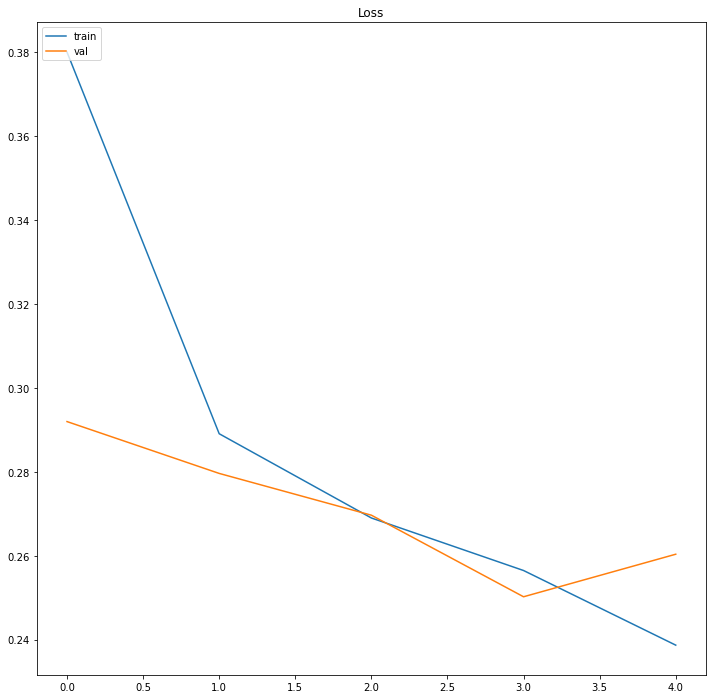

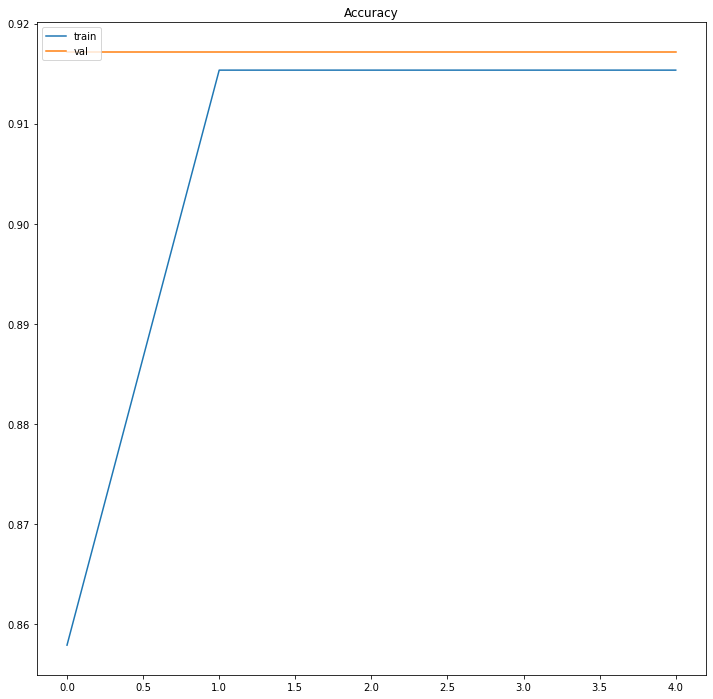

In [170]:
# Plotting Loss and Accuracy Graphs
plt.figure(figsize=(12, 12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 12))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [171]:
from sklearn.metrics import classification_report
import itertools
from sklearn.metrics import confusion_matrix

In [190]:
model.predict(x_test, batch_size=None, verbose=0, steps=None)

array([[0.9654329 , 0.10863569],
       [0.949527  , 0.04715312],
       [0.95784414, 0.10453558],
       [0.9496833 , 0.16553798],
       [0.9578159 , 0.04171029],
       [0.9624979 , 0.0513103 ],
       [0.9577716 , 0.10620251],
       [0.95503986, 0.06198111],
       [0.9597279 , 0.17811987],
       [0.9607996 , 0.07884261],
       [0.9541684 , 0.06937832],
       [0.9596983 , 0.10473087],
       [0.9636623 , 0.10975078],
       [0.95729077, 0.0722954 ],
       [0.9602735 , 0.1076169 ],
       [0.96316504, 0.05049834],
       [0.9617244 , 0.09121984],
       [0.9629736 , 0.06702778],
       [0.96111387, 0.12455866],
       [0.9633783 , 0.07919583],
       [0.9549997 , 0.04646993],
       [0.957983  , 0.06010085],
       [0.9523859 , 0.19154647],
       [0.9588258 , 0.04168308],
       [0.9530443 , 0.0156503 ],
       [0.9514011 , 0.13974112],
       [0.9557445 , 0.13885117],
       [0.9620153 , 0.01835003],
       [0.93825424, 0.04345661],
       [0.9543998 , 0.09195828],
       [0.

In [187]:
y_predict = model.predict(x_test, batch_size=None, verbose=0, steps=None)
mat = confusion_matrix(y_test,y_predict)
print("accuracy score:", accuracy_score(y_test, y_predict))

ValueError: You appear to be using a legacy multi-label data representation. Sequence of sequences are no longer supported; use a binary array or sparse matrix instead - the MultiLabelBinarizer transformer can convert to this format.

In [183]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [186]:
y_pred = model.predict(x_test, batch_size=None, verbose=0, steps=None)

#y_pred = convert_to_labels(y_predict)
y_true = y_test
target_names = [ 'Suicide_pos','Suicide_neg']
#print(classification_report(y_true, y_pred, target_names=target_names))

plt.figure()
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes=target_names,normalize=True)

plt.show()

ValueError: You appear to be using a legacy multi-label data representation. Sequence of sequences are no longer supported; use a binary array or sparse matrix instead - the MultiLabelBinarizer transformer can convert to this format.

<Figure size 432x288 with 0 Axes>